# Problem 7 Part 1

In [1]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt

In [55]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

## Helper Files

In [7]:
def parse_output(outfile):
    """ Parses the quantum espresso output file """
    
    with open(outfile, 'r') as outf:
        for line in outf:
            if (line.lower().startswith('     lattice parameter (alat)')):
                lattice_constant = float(line.split()[-2]) * 0.529177
            if (line.lower().startswith('!    total energy')):
                total_energy = float(line.split()[-2]) * 13.605698066
            #if (line.lower().startswith('     atom    2 type  1   force')):
            #    test_string = line.split()
            #    x = test_string[-1]
            #    y = test_string[-2]
            #    z = test_string[-3]
            #    atom_force = force(x,y,z)
    
    #result = {'energy': total_energy, 'lattice': lattice_constant, 'force': atom_force}
    result = {'energy': total_energy, 'lattice': lattice_constant}
    return result 

In [3]:
def lattice_subs(file, lattice_constant):
    """ opens input file file and changes value for celldm(1) = lattice constant """
    
    # prepare new string
    new_string = "    celldm(1) = " + str(lattice_constant) + ",\n"
    
    # open the file 
    with open(file,'r') as input_file:
        lines = input_file.readlines()
    with open(file, 'w') as input_file:
        for line in lines:
            if line.split()[0] == 'celldm(1)':
                input_file.write(new_string)
            else:
                input_file.write(line) 

In [4]:
lattice_array = np.linspace(9.7, 11.7, 10)

In [5]:
def energy_vs_lattice(lattice_array):
    """ performs problem 7 part 1 calculations """
    
    # declare energy array of same size as cut off array 
    energy_array = np.zeros(len(lattice_array))
    
    for i in range(len(lattice_array)):
        # update input file 
        lattice_subs("Ge.scf.in", lattice_array[i])
        
        # call pw.x 
        subprocess.run('pw.x -in Ge.scf.in > ge.scf.out', shell=True)
        
        # parse output file 
        result = parse_output('ge.scf.out')
        
        # get force and append to array 
        energy_array[i] = result['energy']
        
    return energy_array

In [11]:
energy = energy_vs_lattice(lattice_array)

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floatin

### Initial Plotting 
We can plot our initial results and we see that there does appear to be a minimum!

To be more exact though, we can then fit our data to an equation of state. 

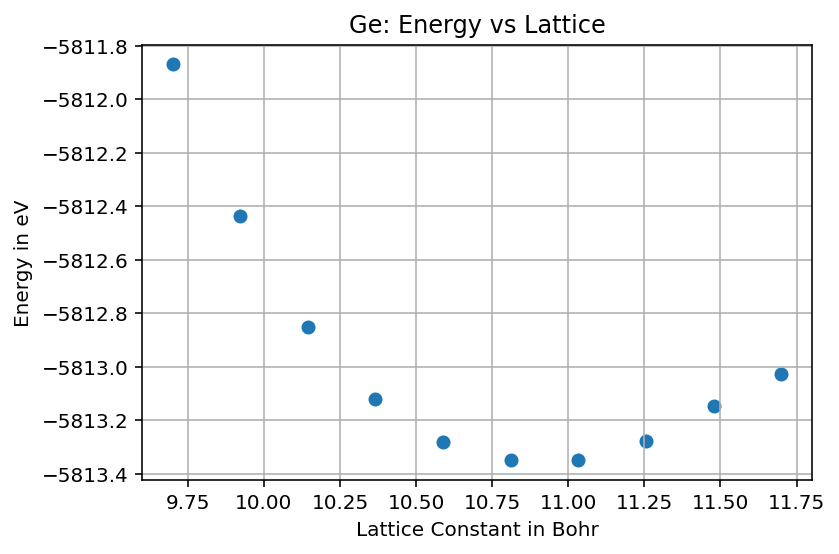

In [56]:
plt.scatter(lattice_array, energy)
#plt.plot(lattice_array, taylor(lattice_array, *popt_taylor), label = 'Taylor')
#plt.plot(lattice_array, murnaghan(lattice_array, *popt_m), label = 'Murnaghan')
#plt.legend()
plt.xlabel('Lattice Constant in Bohr')
plt.ylabel('Energy in eV')
plt.title('Ge: Energy vs Lattice')
plt.grid()
plt.savefig('energy_vs_lat.pdf')

### Murnaghan Equation of State
We would like to fit our data to this equation of state 
$$
    E = E_0 + \frac{9 V_0 B_0}{16}
    \left\{\left[(a_0/a)^2-1\right]^3 B_0' + \left[(a_0/a)^2-1\right]^2[6-4(a_0/a)^2]\right\}
$$
where for FCC $ V_0 = a_0^3/4$. 

We can proceed as follows
1. First we fit using a Taylor series approximation which fits as follows
$$
    E \approx E_0 + \beta (a-a_0)^2
$$
which will approximately fit: $E_0, \beta, a_0$. This then gives us an estimate on $B_0$ the bulk modulus at equilibrium
$$
    B_0 = \frac{2}{9a_0}\beta
$$

2. Using these updated values as guesses, we can then fit to the Murnaghan equation of state. 

In [46]:
from scipy.optimize import curve_fit

In [47]:
def taylor(a, a0, beta, E0):
    return E0 + beta * (a - a0)**2

In [48]:
popt_taylor, pcov_taylor = curve_fit(taylor, lattice_array, energy)

In [49]:
B0_guess = 2/9*(1/popt_taylor[0])*popt_taylor[1]
B0_guess

0.017855258684521782

In [35]:
def murnaghan(a, a0, B0, B0_prime, E0):
    coeff_1 = 9*B0*a0**3/16/4
    brac_1 = ((a0/a)**2 - 1)**3 * B0_prime 
    brac_2 = ((a0/a)**2 - 1)**2 * (6 - 4*(a0/a)**2)
    return E0 + coeff_1 * (brac_1 + brac_2)

In [38]:
popt_m, pcov_m = curve_fit(murnaghan, lattice_array, energy, p0 = [11.00, 0.017855, 0.017855, -5.81340065e+03])

In [39]:
popt_m

array([ 1.09024937e+01,  5.51856847e-02,  4.49749711e+00, -5.81335298e+03])

### Equilibrium Lattice Constant 
From the fitting, we then have $a_0 = 10.902$ Bohr. Compared to the experimental value of 10.7, it does appear to be close! But I suppose it could be improved upon. We could try this with more points. 

### Fitting                                                                                                            

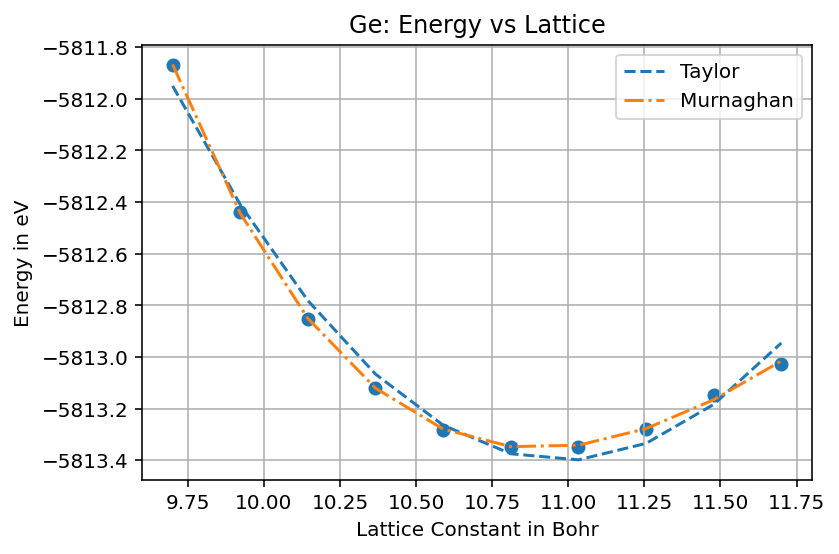

In [57]:
plt.scatter(lattice_array, energy)
plt.plot(lattice_array, taylor(lattice_array, *popt_taylor), label = 'Taylor', linestyle = 'dashed')
plt.plot(lattice_array, murnaghan(lattice_array, *popt_m), label = 'Murnaghan', linestyle = '-.')
plt.legend()
plt.xlabel('Lattice Constant in Bohr')
plt.ylabel('Energy in eV')
plt.title('Ge: Energy vs Lattice')
plt.grid()
plt.savefig('energy_vs_lat_fitted.pdf')

#### Notes
We see that the Murnaghan equation of state fits the data much better than the Taylor approximation does.